In [1]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump

In [2]:
uri = "mongodb://localhost:27017/booking"

client = MongoClient(uri)
db = client.get_default_database()

results = list(db.rooms.find({}, {"facility": 0, "description": 0, "name": 0}))
for item in results:
    _property = db.properties.find_one({"_id": item["property_id"]})
    item["is_near_beach"] = _property["is_near_beach"]
    item["rank"] = _property["rank"]
    item["meal"] = _property["meal"]
    item["distance_from_center"] = _property["distance_from_center"]
    item["city_id"] = _property["city_id"]
    item["property_type_id"] = _property["property_type_id"]

### Sau khi đã có dữ liệu, chuyển thành dạng DataFrame

In [3]:
df = pd.DataFrame(results)
df.head()

,_id,acreage,price,bed_type,property_id,is_near_beach,rank,meal,distance_from_center,city_id,property_type_id
0,5fcb2af4510a272d9c4baed8,14,420,1,8,0,3.9,4,150,2,7
1,5fcb2af4510a272d9c4baed9,12,330,0,27,0,2.8,1,6436,2,3
2,5fcb2af4510a272d9c4baeda,27,320,1,11,1,1.1,3,3005,3,5
3,5fcb2af4510a272d9c4baedb,31,390,1,1,0,3.0,2,1045,1,1
4,5fcb2af4510a272d9c4baedc,24,530,0,3,0,4.7,1,1410,1,3


In [7]:
df = df[["acreage", "bed_type", "distance_from_center", "is_near_beach", "rank", "meal", "city_id", "property_type_id", "price"]]
df.to_csv("data.csv", index=False)

In [4]:
for i in range(len(df)):
    df.at[i, "city_id"] = float(df["city_id"][i])
    df.at[i, "property_type_id"] = float(df["property_type_id"][i])
    
x = np.array(df[["acreage", "bed_type", "distance_from_center", "is_near_beach", "rank", "meal", "city_id", "property_type_id"]])
y = np.array(df["price"])

x = x[:-10]
y = y[:-10]

### Class chuẩn hóa cho price, cơ bản là tìm min, max, min -> 0, max -> 1, revert để tìm lại số ban đầu

In [5]:
class PriceScaler:
    def __init__(self):
        self.mean = 0
        self.scale = 1
        
    def fit(self, x):
        self.mean = min(x)
        self.scale = max(x) - self.mean
    
    def transform(self, x):
        return np.array([(i - self.mean) / self.scale for i in x])
    
    def revert(self, x):
        return x * self.scale + self.mean

### Train model linear

Score:  0.8615050747681532
Predict:  408.2299560007969
Real:  410.0


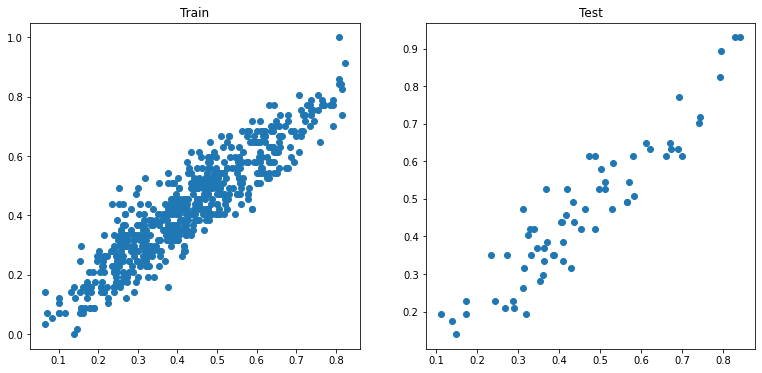

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Tạo mô hình chuẩn hóa cho x, y
scaler_x = StandardScaler()
scaler_x.fit(x)

scaler_y = PriceScaler()
scaler_y.fit(y)

x_train, x_test, y_train, y_test = train_test_split(
    scaler_x.transform(x), scaler_y.transform(y), test_size=0.1, random_state=42)

linear = LinearRegression()
linear.fit(x_train, y_train)
print("Score: ", linear.score(x_test, y_test))

print("Predict: ", scaler_y.revert(linear.predict([x_test[0]])[0]))
print("Real: ", scaler_y.revert(y_test[0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.scatter(linear.predict(x_train), y_train)
ax1.title.set_text("Train")
ax2.scatter(linear.predict(x_test), y_test)
ax2.title.set_text("Test")

In [ ]:
# Xem tham số của mô hình chuẩn hóa
scaler_x.mean_, scaler_x.scale_

# Xuất ra file để về sau dùng lại, ko cần fit nữa
dump(scaler_x, 'scaler_x.model')
dump(scaler_y, 'scaler_y.model')
dump(linear, 'linear.model')

### Train model Neural network

In [ ]:
import keras

from keras.layers import Dense
from keras.models import Sequential

learning_rate = 0.001

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(8, )))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learning_rate))

model.fit(x_train, y_train, batch_size=128, epochs=100)
model.save('neural.h5')

print("Predict: ", scaler_y.revert(model.predict(np.array([x_test[0]]))[0][0]))
print("Real: ", scaler_y.revert(y_test[0]))

### Load

In [ ]:
from joblib import load
from keras.models import load_model

scaler_x = load('scaler_x.model')
scaler_y = load('scaler_y.model')
linear = load('linear.model')
neural = load_model('neural.h5')

### Với bản ghi mới

In [ ]:
d = {
    'acreage': 14,
    'bed_type': 1,
    'is_near_beach': 0,
    'rank': 3.9,
    'meal': 4,
    'distance_from_center': 150,
    'city_id': '2',
    'property_type_id': '7'
}

d["city_id"] = float(d["city_id"])
d["property_type_id"] = float(d["property_type_id"])

df = pd.DataFrame(d, [0])
x = np.array(
    df[["acreage", "bed_type", "distance_from_center", "is_near_beach", "rank", "meal", "city_id", "property_type_id"]])

x = scaler_x.transform(x)

# Real 420

l = linear.predict(x)[0]
print("Linear: ", scaler_y.revert(l))
n = neural.predict(x)
print("Neural: ", scaler_y.revert(n)[0][0])

In [ ]:
x = scaler_x.transform(x)
y = scaler_y.transform(y)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.scatter(linear.predict(x), y)
ax1.title.set_text("Linear Regression")
ax2.scatter(neural.predict(x), y)
ax2.title.set_text("Neural Network")